In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
# build the vocabulary of chars and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [90]:
# build the dataset

block_size = 3
X, Y = [], []

for w in words:
    context= [0] * block_size
    for ch in w + '.':
        idx = stoi[ch]
        X.append(context)
        Y.append(idx)
        #print(''.join(itos[i] for i in context), '----->', itos[idx])
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [91]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [191]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context= [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join(itos[i] for i in context), '----->', itos[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [92]:
C = torch.randn((27, 2))
C

tensor([[ 1.3641,  1.0814],
        [-0.6374, -0.3055],
        [ 0.1882, -0.5804],
        [-1.7993, -0.1860],
        [ 4.7203,  1.4619],
        [-0.4963,  0.9745],
        [ 1.2376, -0.0343],
        [-0.2045,  1.6845],
        [ 0.9459, -0.2593],
        [-0.2122,  0.1166],
        [-0.0761,  0.4059],
        [ 0.9868, -1.4830],
        [ 0.4022,  0.7589],
        [-0.4284,  1.7064],
        [-0.4095, -1.5991],
        [ 0.2088, -1.3175],
        [-0.3787, -1.7861],
        [-2.2623,  0.5770],
        [-1.1636,  1.0130],
        [-0.9563,  1.0981],
        [-0.6610, -1.4106],
        [-0.4960,  0.1831],
        [ 0.8693, -1.4546],
        [-0.1134,  1.1734],
        [ 0.6183,  1.4298],
        [-1.7271,  0.0697],
        [-1.5540,  1.6630]])

In [39]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [40]:
W1 = torch.rand((6, 100))
b1 = torch.randn(100)

In [52]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [53]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [54]:
logits = h @ W2 + b2

In [55]:
logits.shape

torch.Size([32, 27])

In [57]:
counts = logits.exp()

In [58]:
prob = counts / counts.sum(1, keepdim=True)

In [62]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(10.2639)

In [63]:
# put it all together

In [287]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [288]:
sum(p.nelement() for p in parameters)

11897

In [289]:
for p in parameters:
    p.requires_grad = True

In [290]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [301]:
for i in range(200000):
    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (32,))
        
    # forward pass
    emb = C[Xtr[idx]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2                      # (32, 27)
    loss = F.cross_entropy(logits, Ytr[idx])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # keep stats
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
#print(loss.item())

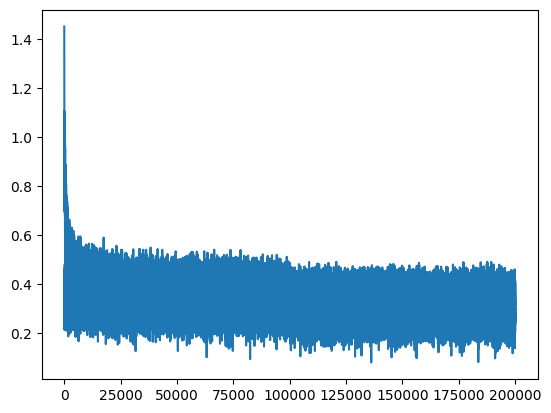

In [302]:
plt.plot(stepi, lossi)

In [303]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2                      # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1322, grad_fn=<NllLossBackward0>)

In [304]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2                      # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0790, grad_fn=<NllLossBackward0>)

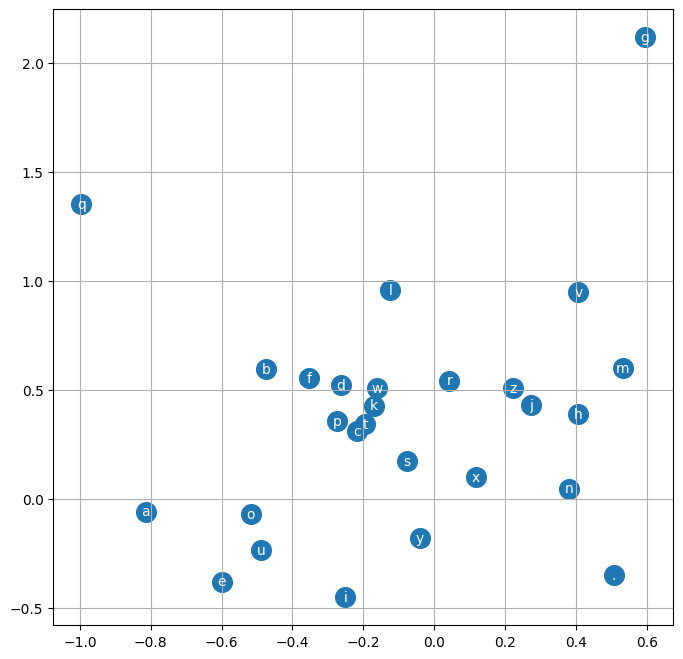

In [241]:
plt.figure(figsize=[8,8])
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [300]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amille.
khi.
mili.
thil.
halaysa.
jazonen.
den.
arci.
aqui.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
shon.
malianni.
wajermadiarisi.
jaxeenitsan.
